In [25]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import cupy # CUDA interface for python

time: 957 µs


In [26]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.98 ms


In [27]:
a = sciIO.readsav('../B0.sav')
print(a.keys())

dict_keys(['twbox'])
time: 3.81 s


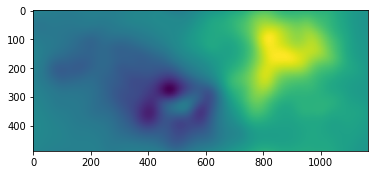

time: 3.87 s


In [28]:
# need to be transposed because of the storage toplogy
Bx = np.transpose(a.twbox[0].bx,(2,1,0)).astype(np.float32)
By = np.transpose(a.twbox[0].by,(2,1,0)).astype(np.float32)
Bz = np.transpose(a.twbox[0].bz,(2,1,0)).astype(np.float32)
#Bx = np.transpose(a.bx,(2,1,0)).astype(np.float32)
#By = np.transpose(a.by,(2,1,0)).astype(np.float32)
#Bz = np.transpose(a.bz,(2,1,0)).astype(np.float32)

Bx_gpu = np.zeros(0)
By_gpu = np.zeros(0)
Bz_gpu = np.zeros(0)

plt.imshow(Bz[:,:,50].T) # x,y.z
#plt.imshow(Bz[:,:,0].T)
flag_init=False

In [29]:
import numpy
import os

print('compiling kernel')
PWD = os.getcwd()
traceFunc_file = open("TraceBlineAdaptive.cu", "rt")
TraceFunc =cupy.RawModule(code=traceFunc_file.read(),backend='nvcc',options=("-I "+PWD,))#, include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
TraceAllBline = TraceFunc.get_function("TraceAllBline")
#print('kernel compiled')

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = cupy.array(Bx)
    By_gpu = cupy.array(By)
    Bz_gpu = cupy.array(Bz)

compiling kernel
transfering B-field to GPU
time: 1.02 s


In [30]:
# prepare variables
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape
print(BshapeN)
BshapeN = cupy.array(BshapeN)

interp_ratio=4
stride_step=1/interp_ratio
x_range = [0,1163]
y_range = [0,487]
#x_range = [350,670]
#y_range = [200,400]

x_i = cupy.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=cupy.float32)
y_i = cupy.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=cupy.float32)
x_arr,y_arr = cupy.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten()
y_inp = y_arr.flatten()
z_inp = (cupy.zeros_like(x_inp,cupy.float32)+23.583333
)
#z_inp[:] = +23.583333

if not flag_init:
    (x_start,y_start,z_start, x_end,y_end,z_end,
     Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
    )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    flag_init=True

line_len = cupy.zeros(x_inp.shape,cupy.float64)
N        = cupy.array([x_inp.shape[0]],cupy.ulonglong)
s_len    = cupy.array([1./4.],cupy.float32)
tol_coef    = cupy.array([1.],cupy.float32)

# for GTX 1060
#blck=(64,1,1)
#grd = (20,1)

# for GTX1080ti
blck=(128,1,1)
grd = (28,1)
cupy.cuda.stream.get_current_stream().synchronize()

[1164  488  488]
time: 37 ms


In [31]:
# run the big calclation
TraceAllBline(blck,grd,
            (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
            x_inp,   y_inp,   z_inp,
            x_start, y_start, z_start, flag_start,
            x_end,   y_end,   z_end,   flag_end,
            Bx_inp,  By_inp,  Bz_inp,  B_flag,
            Bx_start,By_start,Bz_start,
            Bx_end,  By_end,  Bz_end,  
            s_len,N,line_len, tol_coef))
cupy.cuda.stream.get_current_stream().synchronize()

time: 4.25 s


In [32]:
import FastQSL

time: 999 µs


In [33]:
(x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
 x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
 Bx_in_arr,   By_in_arr,  Bz_in_arr,
 Bx_out_arr,  By_out_arr, Bz_out_arr,
 Bz_0_arr,    B_flag_arr) = FastQSL.ResReshape(xy_shape,
                x_end,y_end,z_end,flag_end,
                x_start,y_start,z_start,flag_start,
                Bx_start,By_start,Bz_start,
                Bx_end,By_end,Bz_end,
                Bz_inp,B_flag)
Q=FastQSL.QCalcPlane(x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
     x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
     Bx_in_arr,   By_in_arr,  Bz_in_arr,
     Bx_out_arr,  By_out_arr, Bz_out_arr,
     Bz_0_arr,    B_flag_arr, stride_step)
cupy.cuda.stream.get_current_stream().synchronize()

time: 45 ms


In [34]:
stride_this  =  cupy.float32(1./interp_ratio)/8

time: 988 µs


In [35]:
(cut_inp_x,   cut_inp_y,   cut_inp_z,
    cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
    cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
    Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
    Bx_start_cut,By_start_cut,Bz_start_cut,
    Bx_end_cut,  By_end_cut,  Bz_end_cut,  
    N_cut,line_len_cut,Bz0_start, Bz0_end)=FastQSL.CookPseudoLine(
         x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
         x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
         Bx_in_arr,   By_in_arr,  Bz_in_arr,
         Bx_out_arr,  By_out_arr, Bz_out_arr,
         Bz_0_arr,    B_flag_arr, stride_this)

time: 26 ms


In [36]:
# run the big calclation
TraceAllBline(blck,grd,
            (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
            cut_inp_x,   cut_inp_y,   cut_inp_z,
            cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
            cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
            Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
            Bx_start_cut,By_start_cut,Bz_start_cut,
            Bx_end_cut,  By_end_cut,  Bz_end_cut,  
            s_len,N_cut,line_len_cut, tol_coef*.1))
cupy.cuda.stream.get_current_stream().synchronize()

time: 89 ms


In [49]:
(X1,Y1,X2,Y2) = [cupy.zeros(cut_inp_x.shape,dtype=cupy.float32) 
                 for _ in range(4)];

idx_Z1_cut=(flag_cut_start-1)//2 == 2;  idx_Z2_cut=(flag_cut_end-1)//2 == 2
idx_Y1_cut=(flag_cut_start-1)//2 == 1;  idx_Y2_cut=(flag_cut_end-1)//2 == 1
idx_X1_cut=(flag_cut_start-1)//2 == 0;  idx_X2_cut=(flag_cut_end-1)//2 == 0

# Z plane
X1[idx_Z1_cut] = cut_start_x[idx_Z1_cut]; Y1[idx_Z1_cut] = cut_start_y[idx_Z1_cut] 
X2[idx_Z2_cut] = cut_end_x[idx_Z2_cut];   Y2[idx_Z2_cut] = cut_end_y[idx_Z2_cut] 
# Y plane
X1[idx_Y1_cut] = cut_start_z[idx_Y1_cut]; Y1[idx_Y1_cut] = cut_start_x[idx_Y1_cut]
X2[idx_Y2_cut] = cut_end_z[idx_Y2_cut];   Y2[idx_Y2_cut] = cut_end_x[idx_Y2_cut]
# X plane
X1[idx_X1_cut] = cut_start_y[idx_X1_cut]; Y1[idx_X1_cut] = cut_start_z[idx_X1_cut]
X2[idx_X2_cut] = cut_end_y[idx_X2_cut];   Y2[idx_X2_cut] = cut_end_z[idx_X2_cut]

dx2xc = X2[0::4]-X2[2::4]; dx2yc = X2[1::4]-X2[3::4];
dy2xc = Y2[0::4]-Y2[2::4]; dy2yc = Y2[1::4]-Y2[3::4];

dx1xc = X1[0::4]-X1[2::4]; dx1yc = X1[1::4]-X1[3::4];
dy1xc = Y1[0::4]-Y1[2::4]; dy1yc = Y1[1::4]-Y1[3::4];

a_cut = (dx2xc*dy1yc-dx2yc*dy1xc);
b_cut = (dx2yc*dx1xc-dx2xc*dx1yc);
c_cut = (dy2xc*dy1yc-dy2yc*dy1xc);
d_cut = (dy2yc*dx1xc-dy2xc*dx1yc);

bnr_cut = cupy.abs(Bz0_start)/(cupy.abs(Bz0_end))*((1/stride_this)**4)
Qcut = (a_cut**2+b_cut**2+c_cut**2+d_cut**2)*bnr_cut
Qcut[cupy.where(Qcut<1.0)]=1.0

cupy.cuda.stream.get_current_stream().synchronize()

time: 34 ms


In [50]:
dy2yc

array([-0.6158142, -0.5836487, -0.5777283, ...,  0.       ,  0.       ,
        0.       ], dtype=float32)

time: 4.03 ms


In [51]:
Q_all=cupy.zeros(x_end_arr.shape,dtype=cupy.float32)

Q_all[1:-1,1:-1]=Q
Q_all[B_flag_arr==1]=Qcut
Q_final=Q_all[1:-1,1:-1]


time: 4 ms


In [54]:
Qcut

array([2.4375230e+04, 3.5311828e+04, 7.1124055e+04, ..., 3.1590315e+01,
       3.2850906e+01, 3.3674156e+01], dtype=float32)

time: 16 ms


(250, 500)

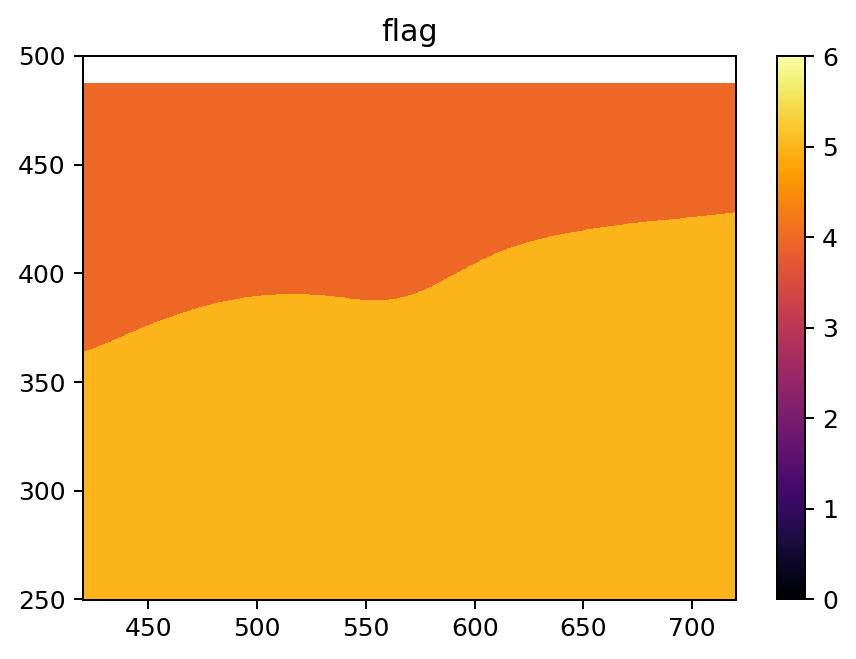

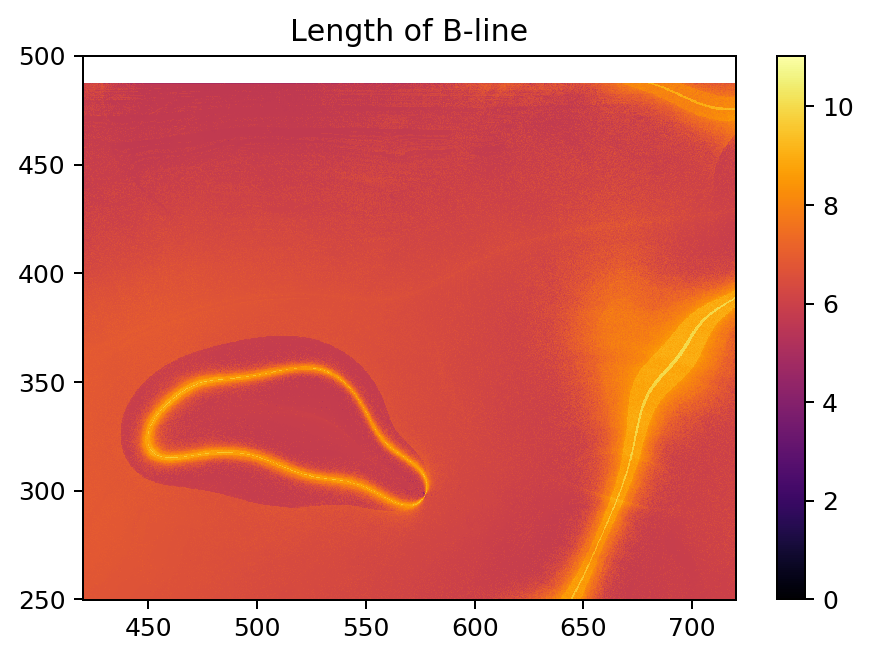

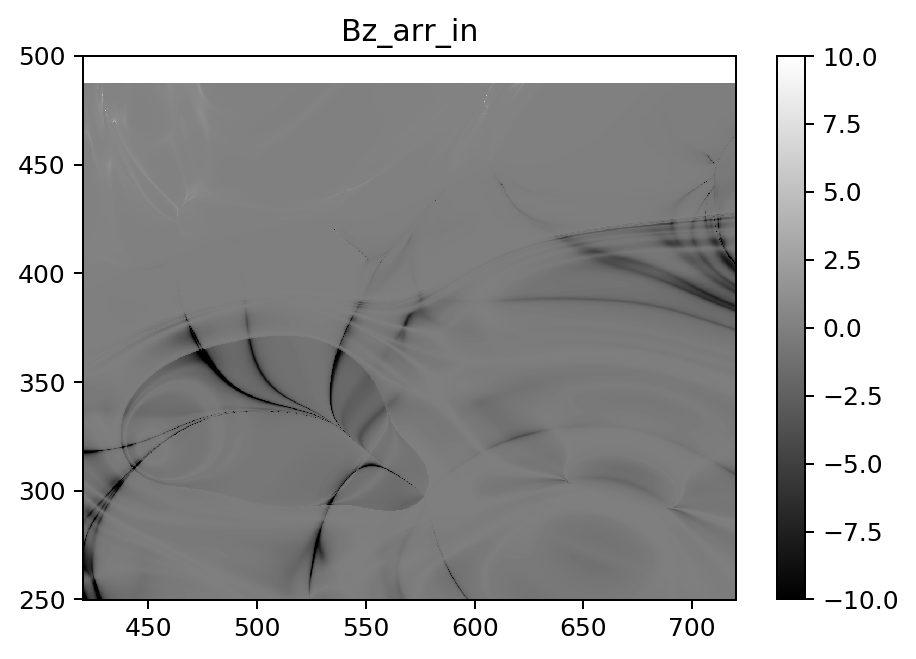

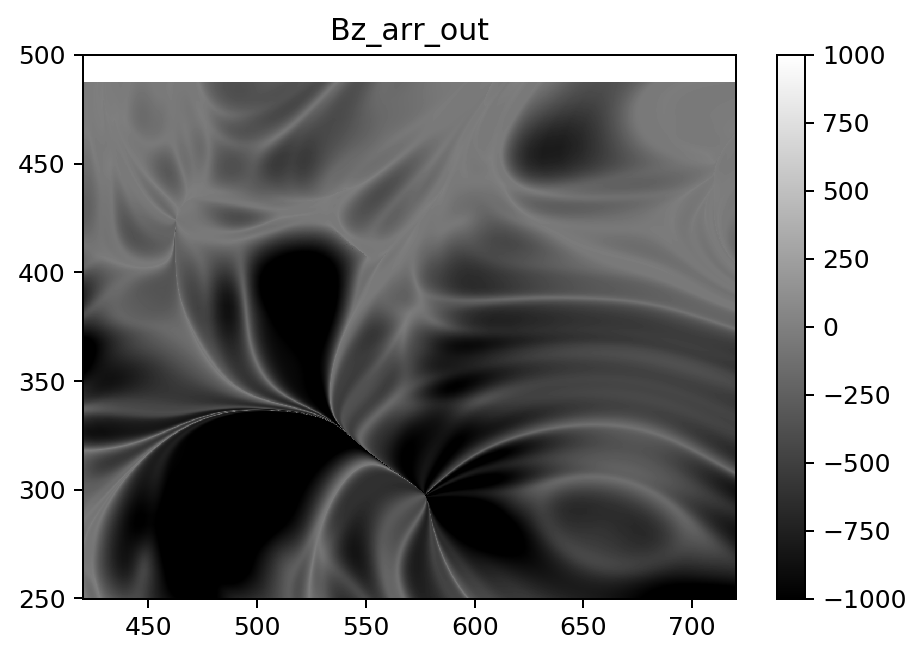

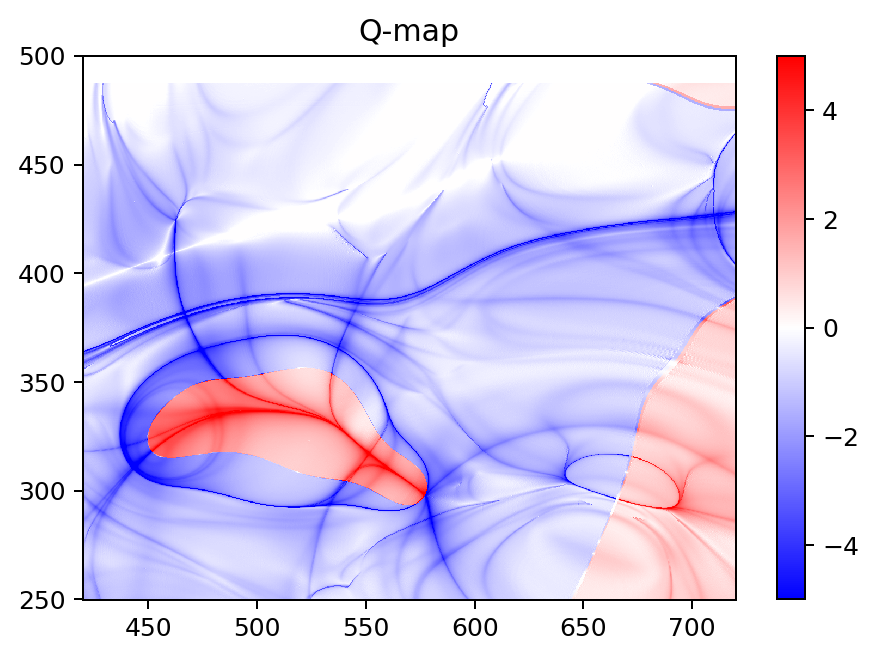

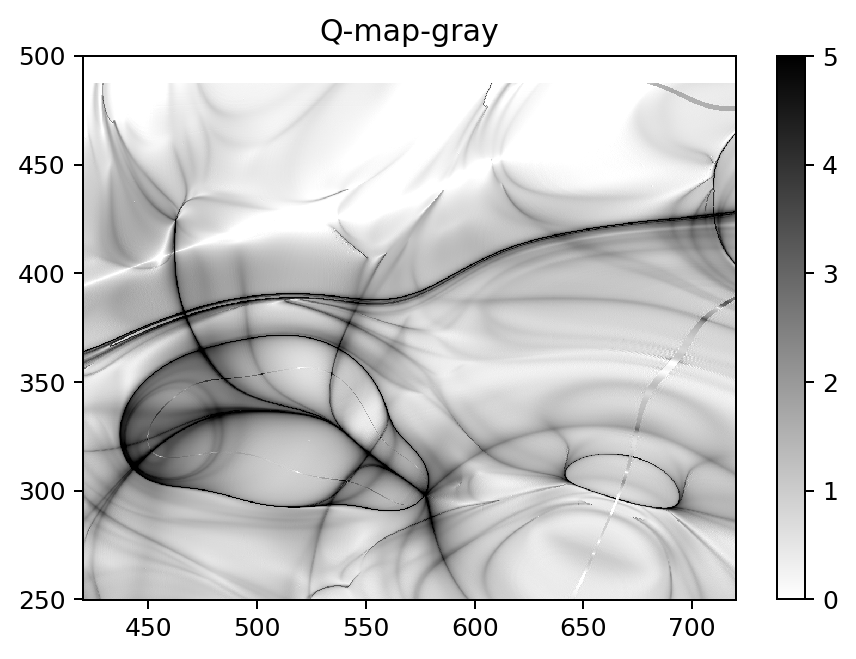

time: 6.52 s


In [53]:
plt.close()

xxlim=None
yylim=None

xxlim=[420,720]
yylim=[250,500]
#xxlim=[550,650]
#yylim=[200,270]
#xxlim= [350,670]
#yylim= [200,400]

dpi=180

fig=plt.figure(0,dpi=dpi); ax = plt.gca() 
img=ax.imshow(flag_start_arr.get(),cmap='inferno',origin='lower',vmin=0,
              extent=[*x_range,*y_range],vmax=6)
fig.colorbar(img)
ax.set_title('flag')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(1,dpi=dpi); ax = plt.gca() 
img=ax.imshow(np.log(line_len.get().reshape(xy_shape)),cmap='inferno',origin='lower',
              vmin=0,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Length of B-line')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_in_arr.get()/Bz_out_arr.get(),cmap='gray',origin='lower',
              vmax=10,vmin=-10,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_in')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_out_arr.get(),cmap='gray',origin='lower',vmax=1000,vmin=-1000,
              extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_out')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(4,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q_final.get())*np.sign(Bz_0_arr.get()[1:-1,1:-1])
                *(flag_start_arr.get()[1:-1,1:-1]<=6),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)



fig=plt.figure(6,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q_final.get())*(flag_start_arr.get()[1:-1,1:-1]<41),
                vmax=5,vmin=0,cmap='gray_r',origin='lower',extent=[*x_range,*y_range])

fig.colorbar(img)
ax.set_title('Q-map-gray')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)




NameError: name 'bnr' is not defined

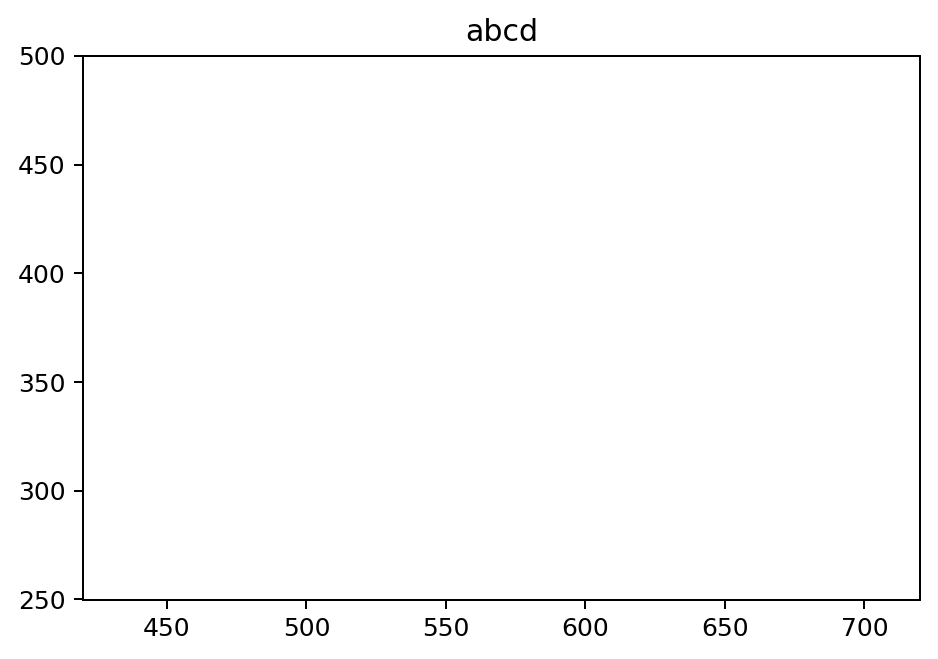

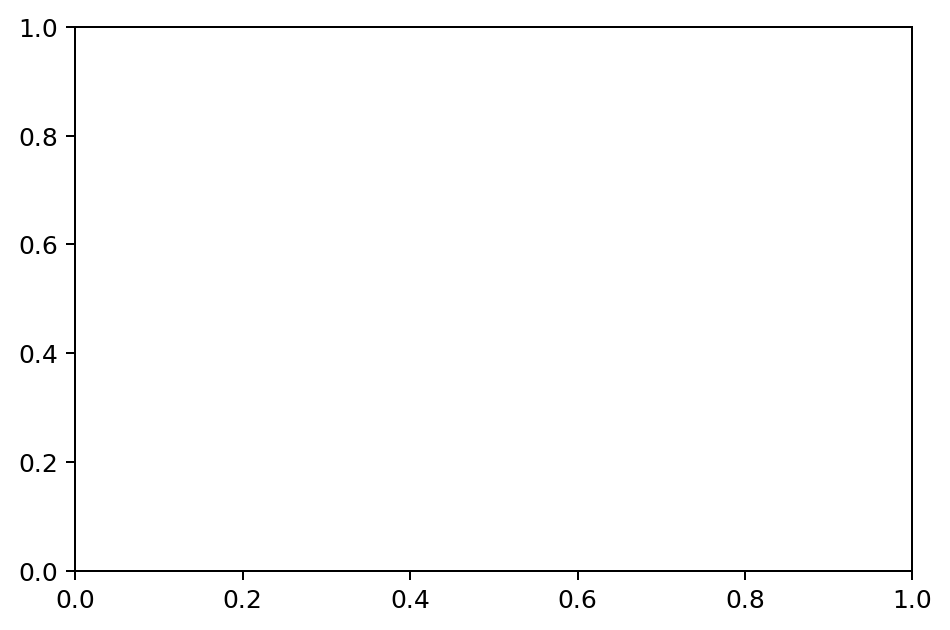

time: 488 ms


In [48]:
fig=plt.figure(1,dpi=180); ax = plt.gca() 
#img = ax.imshow(np.log((b.get())**2),cmap='inferno',origin='lower',extent=[*x_range,*y_range])
#fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=180); ax = plt.gca() 
img = ax.imshow(np.log(bnr.get()),vmax=50,cmap='inferno',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=180); ax = plt.gca() 
img = ax.imshow((B_flag_arr.get()),cmap='inferno',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


In [ ]:

plt.figure(10,figsize=[5,3],dpi=120); ax = plt.gca() 
plt.hist(flag_start.get())
ax.set_title('flag histogram')

plt.figure(11,figsize=[5,3],dpi=120); ax = plt.gca() 
plt.hist(line_len.get())
ax.set_title('Length histogram')

In [ ]:
flags_arr